## Set Up

In [1]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyxdf
import mne

from scipy import signal
from scipy.signal import butter, filtfilt, cwt, morlet, find_peaks, welch, savgol_filter

# Throw away useless metadata from the file
streams, _ = pyxdf.load_xdf("test.xdf")

# Initialize some important variables
for stream in streams:
    if stream["info"]["name"][0] == "BrainAmpSeries-Dev_1":
        # Get the EEG data and sampling rate
        eeg_data = np.array(stream["time_series"])
        sfreq = float(stream["info"]["nominal_srate"][0])
        
        # Create a time axis for the EEG data
        time_axis = np.arange(0, len(eeg_data)) / sfreq
        
        # Get the number of EEG channels
        num_channels = eeg_data.shape[1]

## Information for Streams

In [8]:
# Iterate through each stream
for stream in streams:
    stream_name = stream["info"]["name"][0]
    num_samples = len(stream["time_series"])

    sfreq = None
    duration = None
    
    # Check for sampling rate
    if "nominal_srate" in stream["info"] and float(stream["info"]["nominal_srate"][0]) != 0:
        sfreq = float(stream["info"]["nominal_srate"][0])
        duration = num_samples / sfreq

    print(f"Stream: {stream_name}")
    print(f"    Number of samples: {num_samples}")

    # If sampling rate is present, print its information
    if sfreq is not None:
        print(f"    Sampling rate: {sfreq} Hz")
        print(f"    Duration: {duration:.2f} seconds")
    else:
        print("    Sampling rate: Not available")
        print("    Duration: Not available")

    print()


Stream: CGX AIM Phys. Mon. AIM-0106 Impedance
    Number of samples: 1662973
    Sampling rate: 500.0 Hz
    Duration: 3325.95 seconds

Stream: CGX AIM Phys. Mon. AIM-0106
    Number of samples: 1662973
    Sampling rate: 500.0 Hz
    Duration: 3325.95 seconds

Stream: BrainAmpSeries-Dev_1
    Number of samples: 1578112
    Sampling rate: 500.0 Hz
    Duration: 3156.22 seconds

Stream: ChillsReport
    Number of samples: 57
    Sampling rate: Not available
    Duration: Not available

Stream: RestingStateStart
    Number of samples: 3
    Sampling rate: Not available
    Duration: Not available

Stream: FrissonStart
    Number of samples: 10
    Sampling rate: Not available
    Duration: Not available

Stream: AudioStart
    Number of samples: 4
    Sampling rate: Not available
    Duration: Not available



## Power Spectrum Density Graphs

Creating RawArray with float64 data, n_channels=64, n_times=1578112
    Range : 0 ... 1578111 =      0.000 ...  3156.222 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


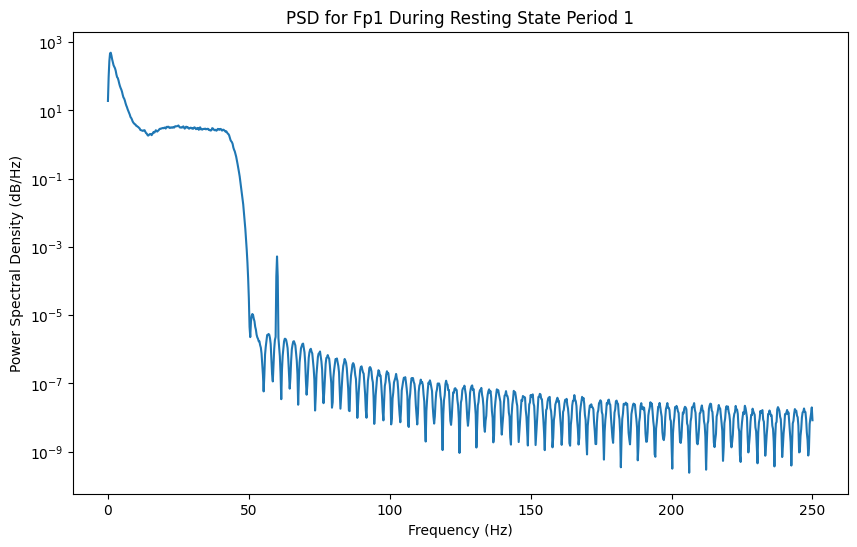

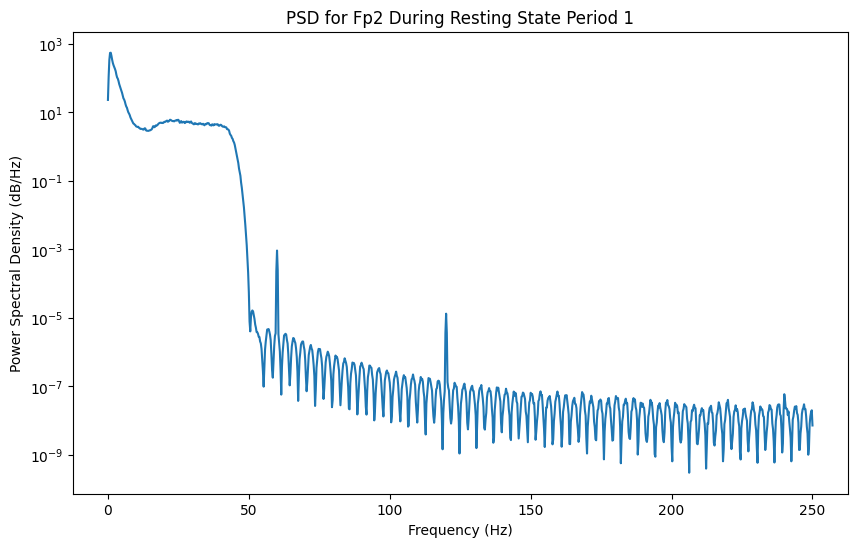

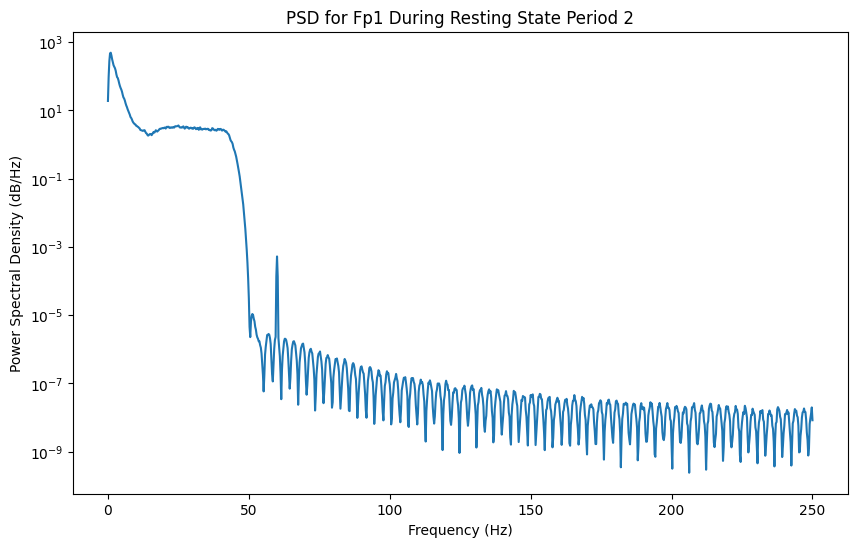

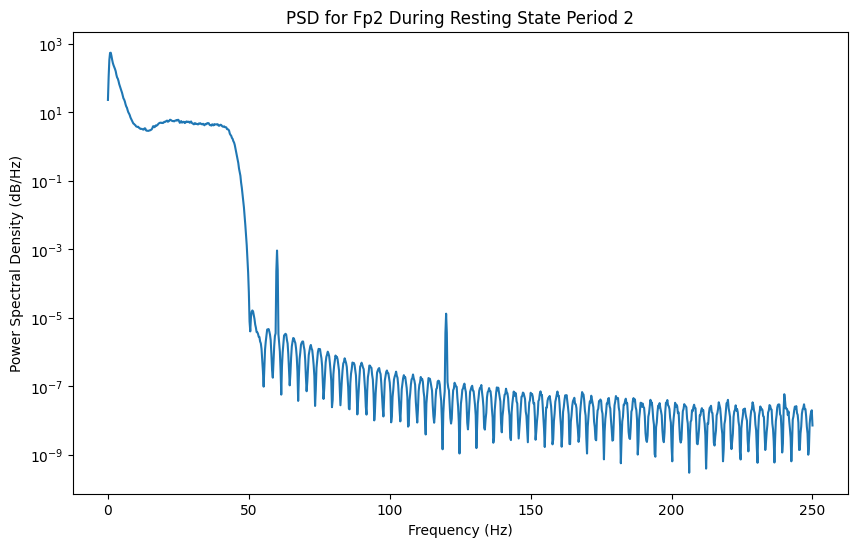

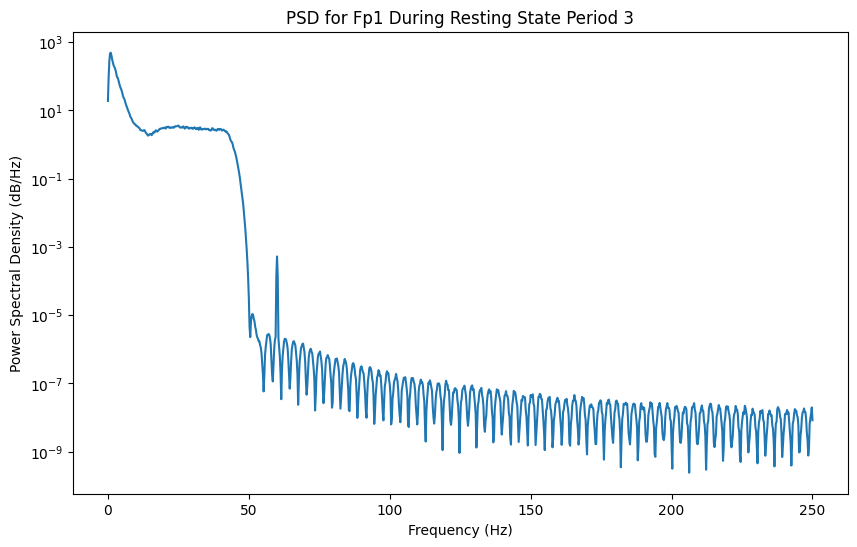

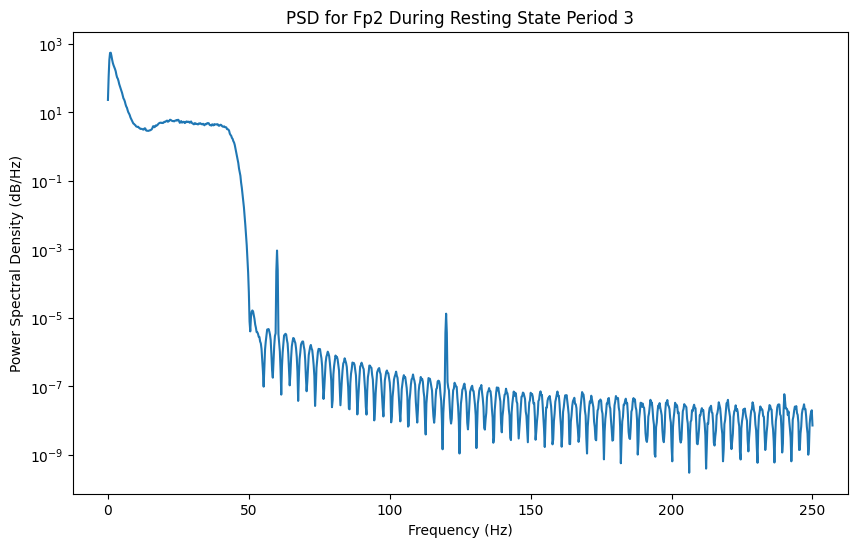

In [9]:
# Initialize variables for EEG data, EEG info, and resting state markers
eeg_data = None
eeg_info = None
resting_state_starts = []

# Identify and extract EEG data and resting state markers
for stream in streams:
    if stream['info']['name'][0] == 'BrainAmpSeries-Dev_1':
        eeg_data = np.array(stream['time_series']).T  # Transpose to make channels as rows
        ch_names = [ch['label'][0] for ch in stream['info']['desc'][0]['channels'][0]['channel']]
        sfreq = float(stream['info']['nominal_srate'][0])
        eeg_info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types = 'eeg')
    elif stream['info']['name'][0] == 'RestingStateStart':
        resting_state_starts.extend(stream['time_stamps'])

# Create MNE Raw object for EEG data
raw = mne.io.RawArray(eeg_data, eeg_info)

# Filter data
raw.filter(1., 40., fir_design = 'firwin')

# Sample channels
channels_to_analyze = ['Fp1', 'Fp2']  

# Compute PSD for the first 2 minutes of each resting state
for i, start_time in enumerate(resting_state_starts): 
    end_time = start_time + 120 
    
    for ch_name in channels_to_analyze:
        ch_data = raw.copy().pick([ch_name]).get_data()[0]  # Get data for the channel
        
        # Compute PSD using Welch's method
        freqs, psd = welch(ch_data, sfreq, nperseg = int(4 * sfreq))  # 4-second window

        # Plotting
        plt.figure(figsize = (10, 6))
        plt.semilogy(freqs, psd)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density (dB/Hz)')
        plt.title(f'PSD for {ch_name} During Resting State Period {i + 1}')
        plt.show()

## Entire EEG Dataset

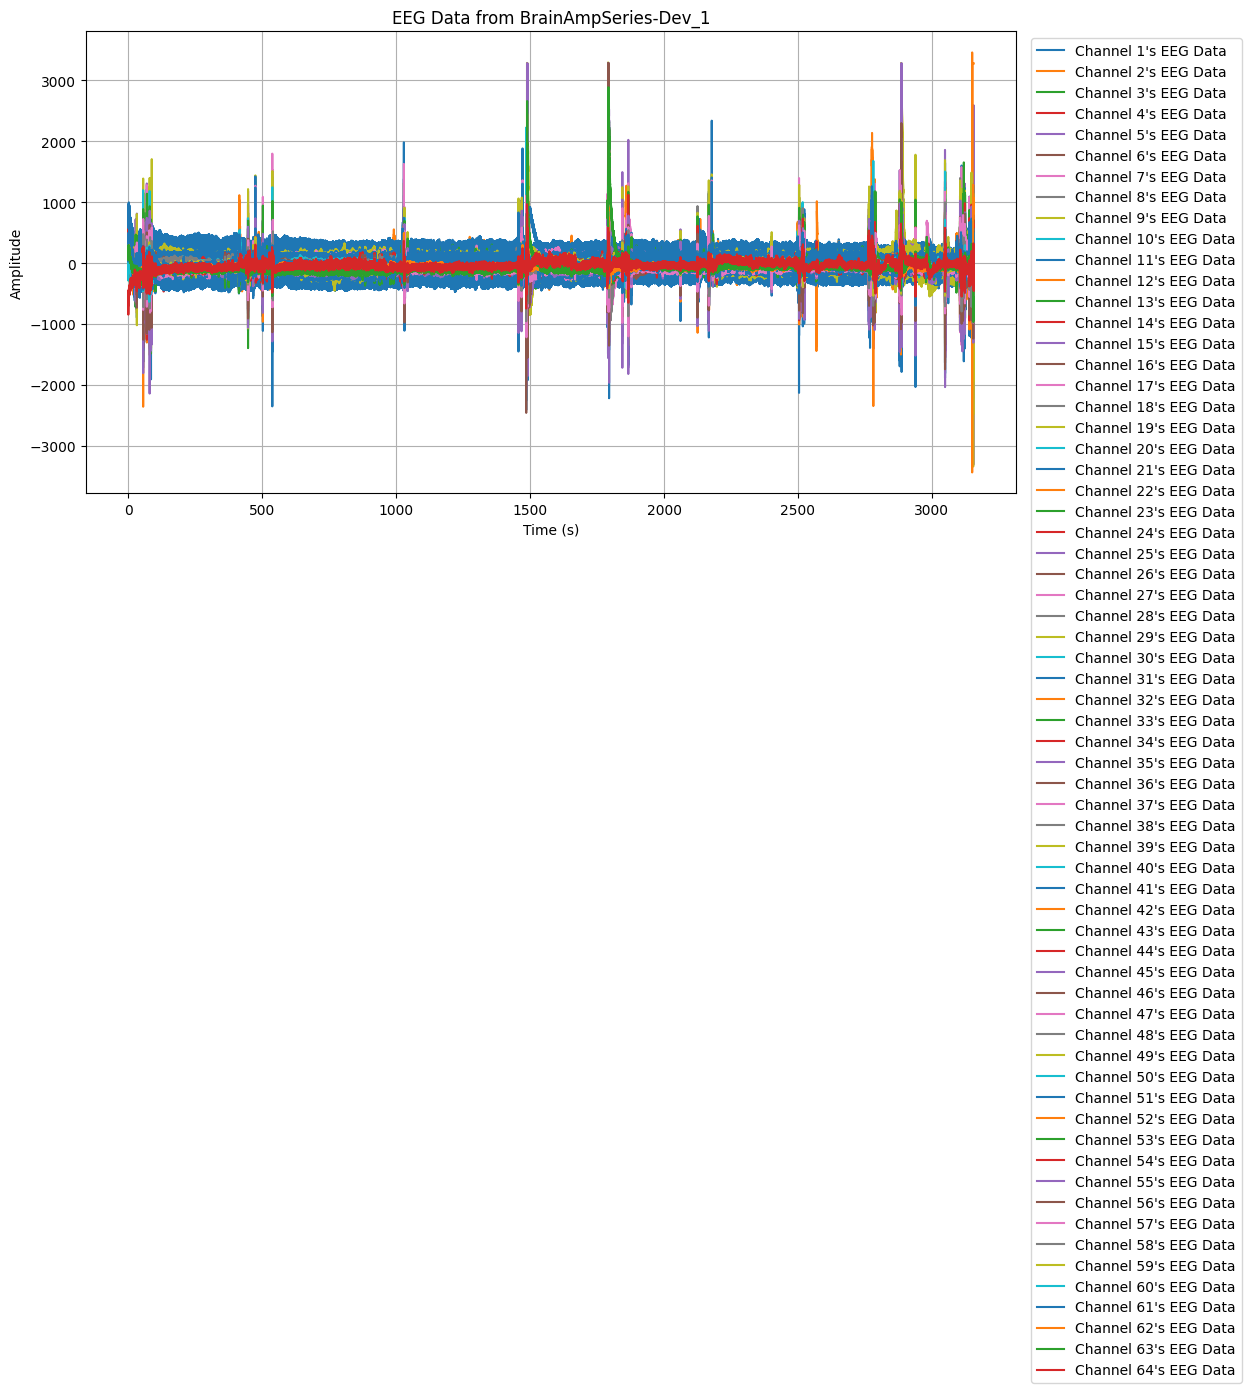

In [11]:
# Initialize the figure
plt.figure(figsize = (12, 6))

for stream in streams:
    if stream["info"]["name"][0] == "BrainAmpSeries-Dev_1":
        # Get the EEG data and sampling rate
        eeg_data = np.array(stream["time_series"])
        sfreq = float(stream["info"]["nominal_srate"][0])
        
        # Create a time axis for the EEG data
        time_axis = np.arange(0, len(eeg_data)) / sfreq
        
        # Plot each channel's EEG data with its label
        for channel in range(eeg_data.shape[1]):
            plt.plot(time_axis, eeg_data[:, channel], label = f"Channel {channel + 1}'s EEG Data")

# Label the plot
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("EEG Data from BrainAmpSeries-Dev_1")
plt.legend(loc = "upper right", bbox_to_anchor = (1.25, 1))  # Adjust the legend position
plt.grid(True)

# Show the plot
plt.show()

## Sample Individual Channels

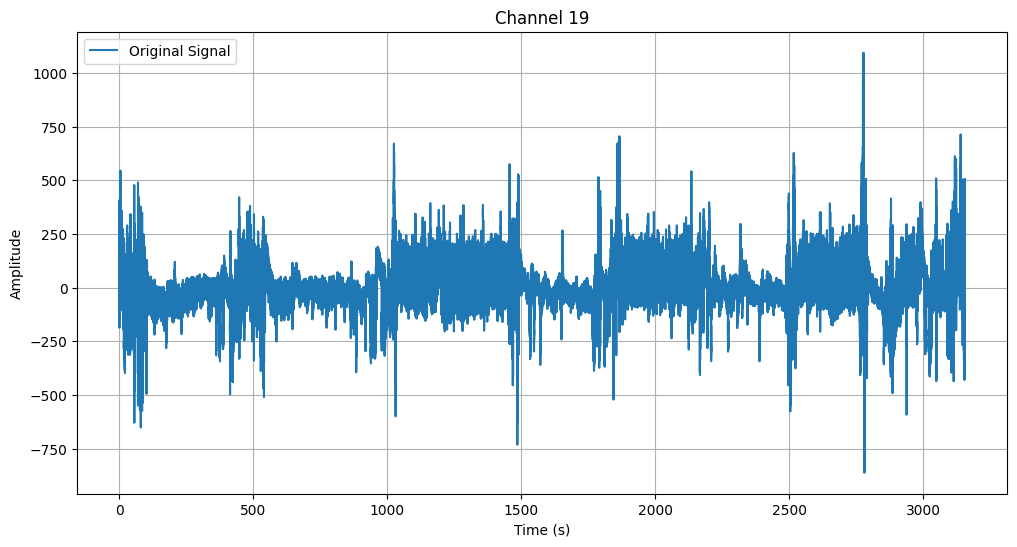

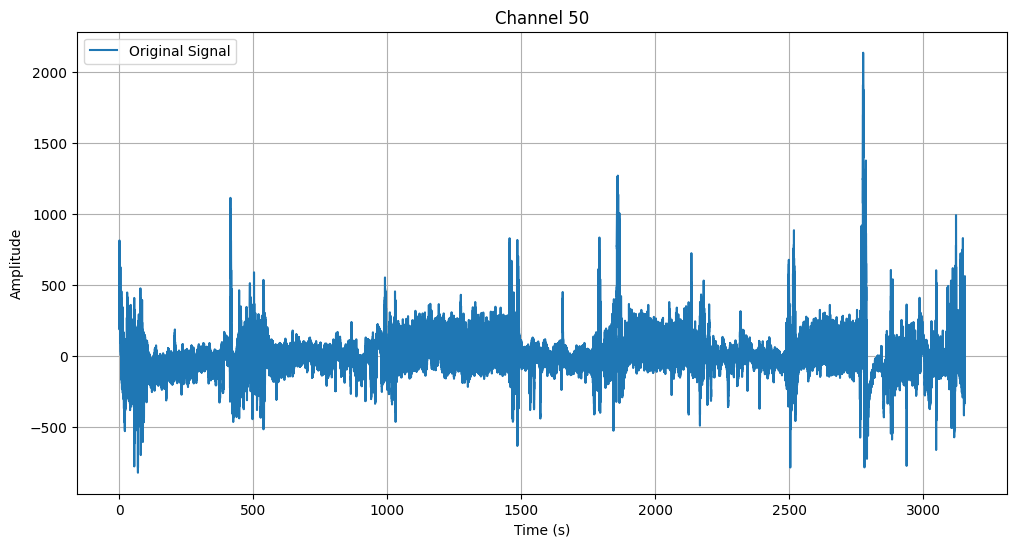

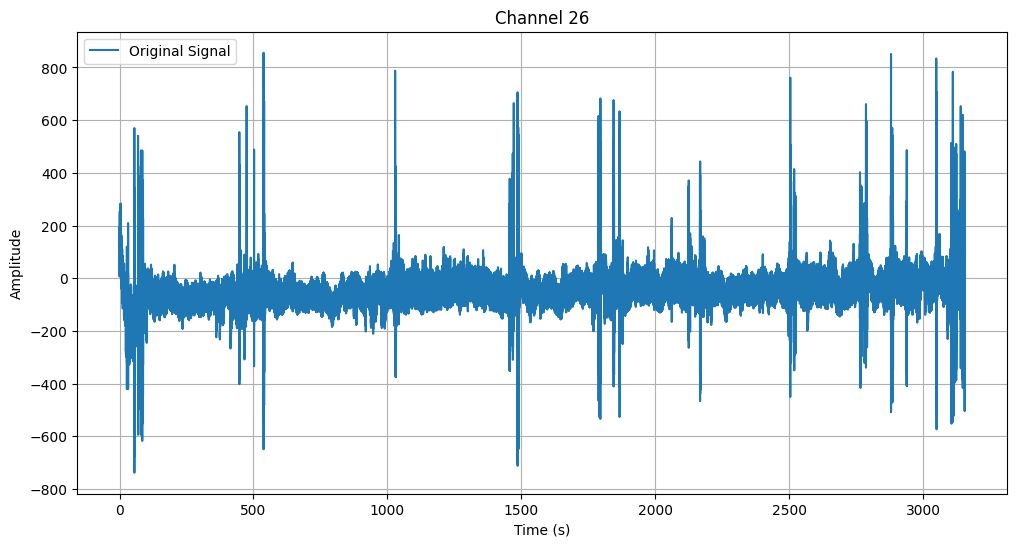

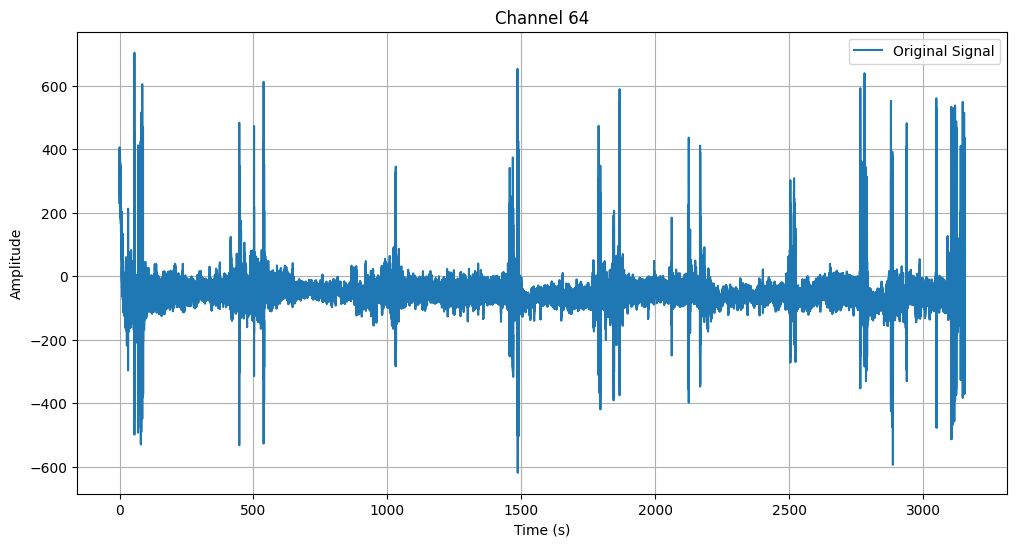

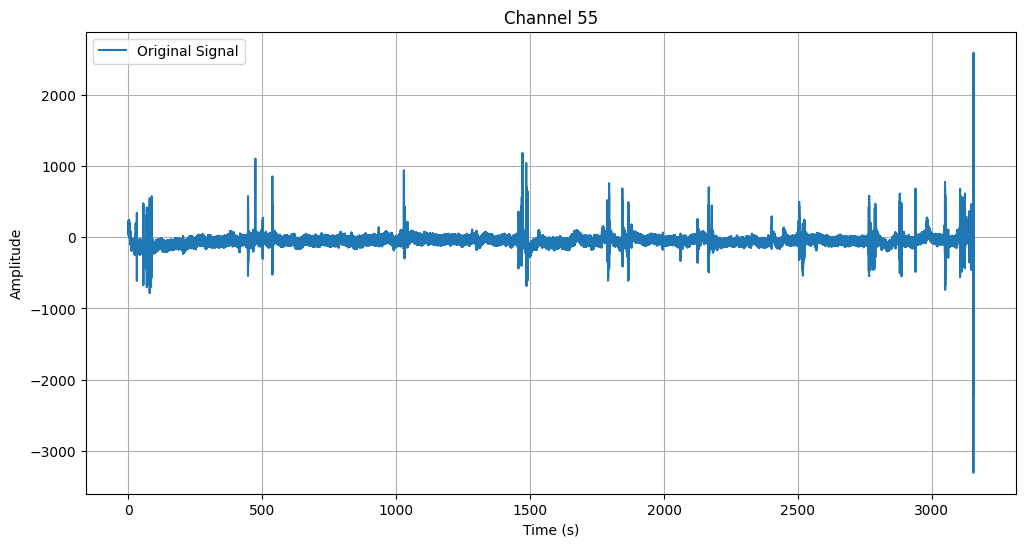

In [12]:
# Get 5 random channels to plot
random_channels = np.random.choice(num_channels, 5, replace = False)
        
for i in range(len(random_channels)):
    # Plot the random channels
    plt.figure(figsize = (12, 6))
    plt.plot(time_axis, eeg_data[:, i], label = 'Original Signal')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Channel {random_channels[i] + 1}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Filters

## Set up variables

In [20]:
# Find the "BrainAmpSeries-Dev_1" stream
for stream in streams:
    if stream["info"]["name"][0] == "BrainAmpSeries-Dev_1":
        # Assuming 'streams' is a list of dictionaries containing EEG data
        channels = stream["info"]["desc"][0]["channels"][0]["channel"]
        channel_names = [ch["label"][0] for ch in channels]
        channel_names_list = []
    
        for i, name in enumerate(channel_names):
            channel_names_list.append(f"Channel {i+1}: {name}")

        # Get the EEG data and sampling rate
        eeg_data = np.array(stream["time_series"])
        sfreq = float(stream["info"]["nominal_srate"][0])
        
        # Create a time axis for the EEG data
        time_axis = np.arange(0, len(eeg_data)) / sfreq
        
        # Get the number of EEG channels
        num_channels = eeg_data.shape[1]

## Bandpass

### Sample Comparison

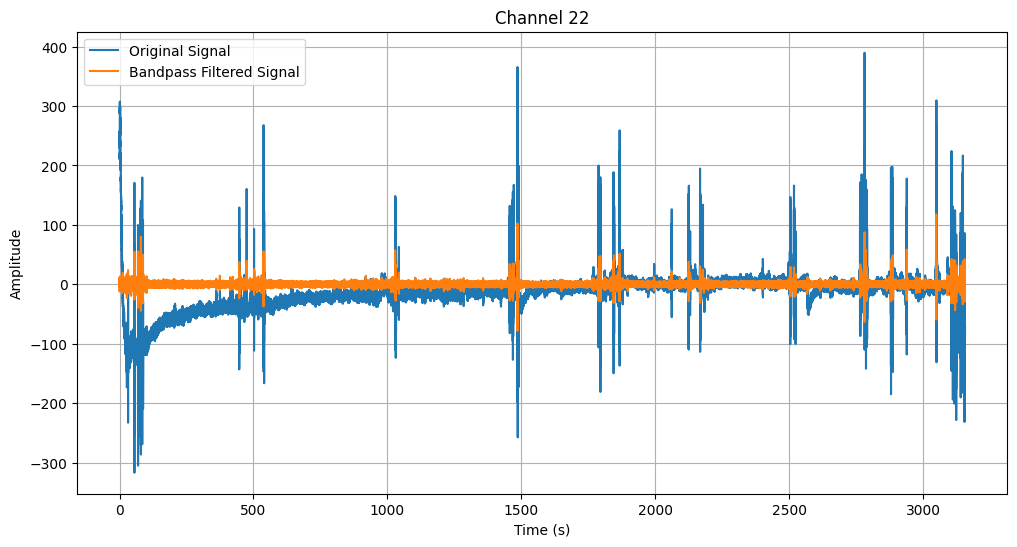

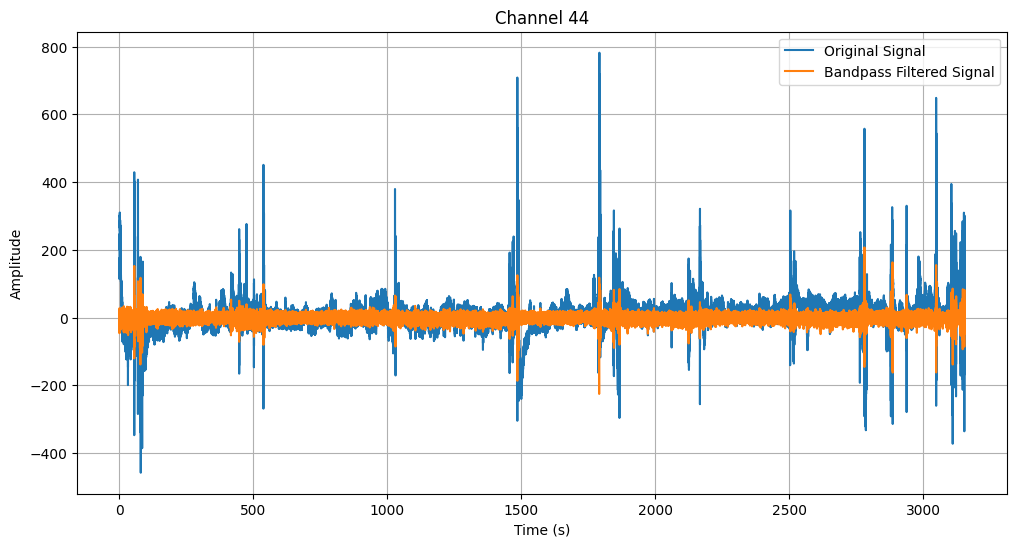

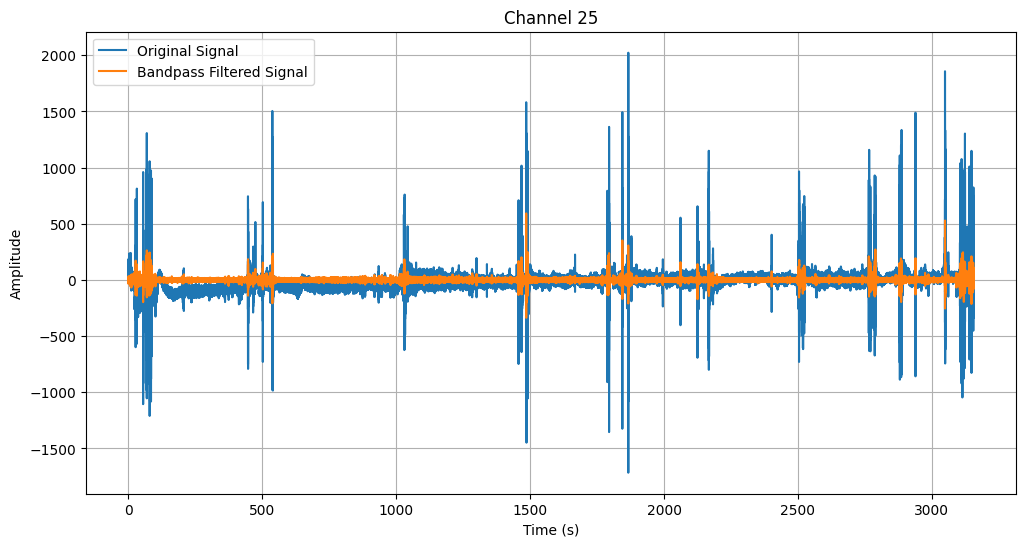

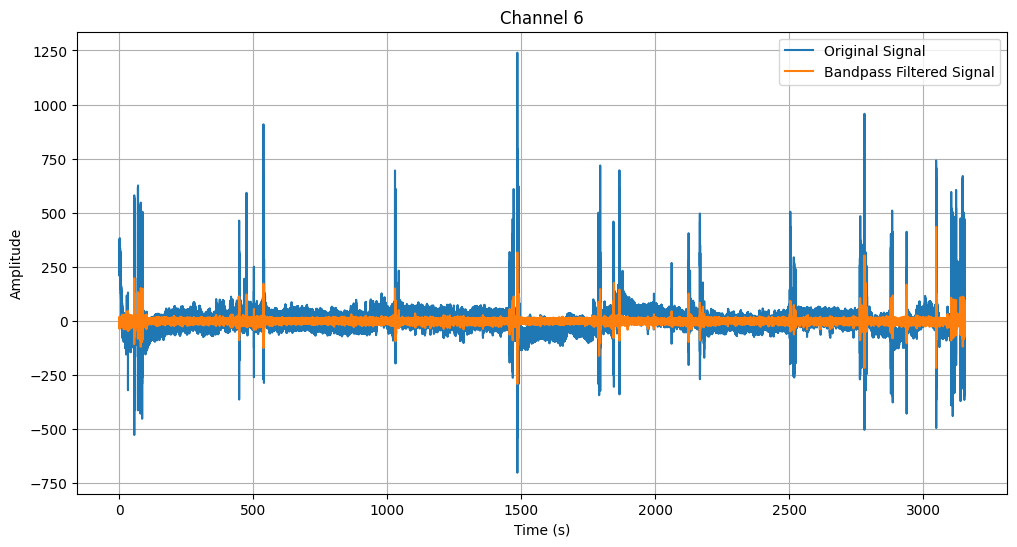

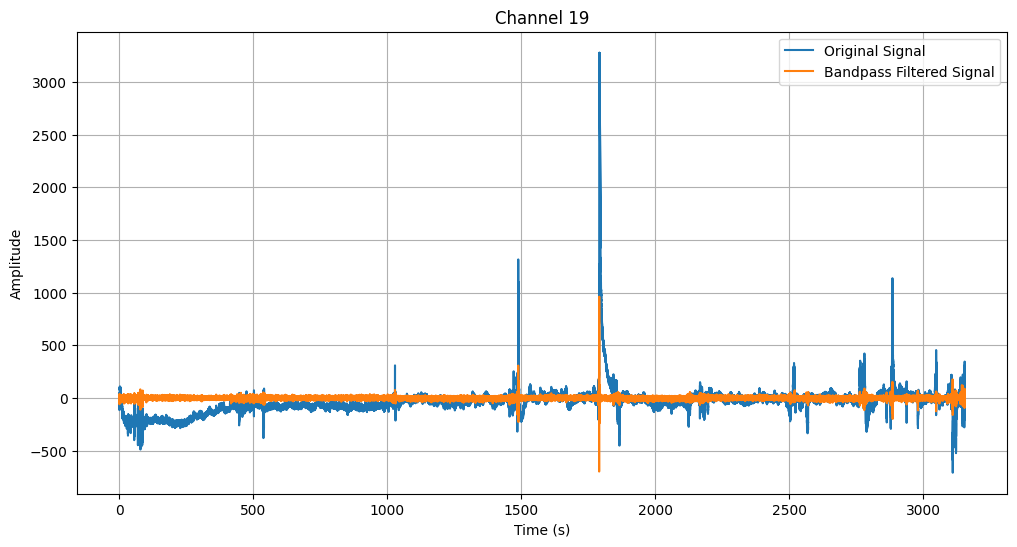

In [10]:
# Function to apply the bandpass filter to EEG data
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Get 5 random channels to plot
random_channels = np.random.choice(num_channels, 5, replace=False)
        
# Plot each EEG channel separately
for i in range(len(random_channels)):
    # Smooth the signal using Savitzky-Golay filter
    smoothed_signal = apply_bandpass_filter(eeg_data[:, random_channels[i]], 0.5, 45, sfreq)
            
    # Plot the original signal, smoothed signal, and identified peaks
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, eeg_data[:, random_channels[i]], label="Original Signal")
    plt.plot(time_axis, smoothed_signal, label="Bandpass Filtered Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Channel {random_channels[i] + 1}")
    plt.legend()
    plt.grid(True)
    plt.show()



### Peak Detection Attempt

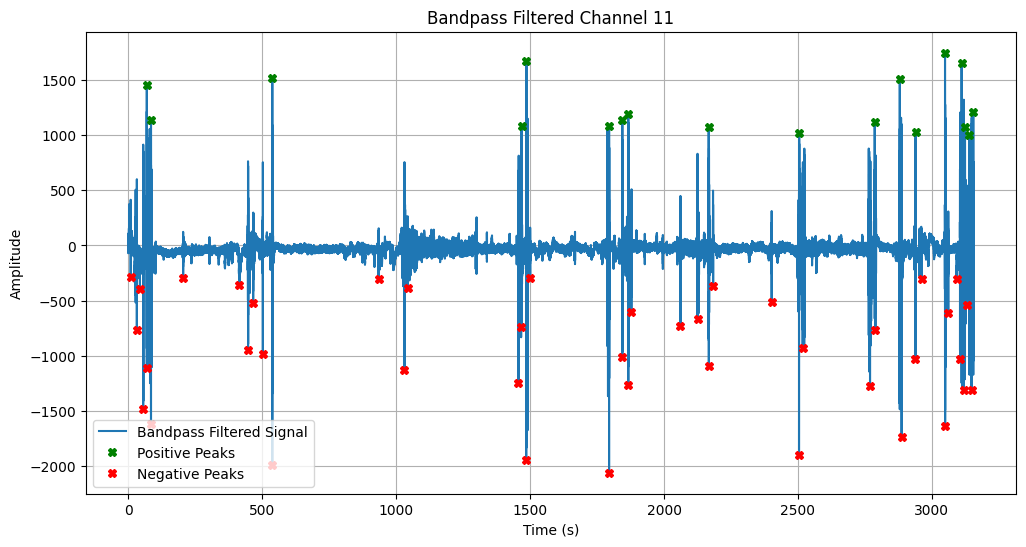

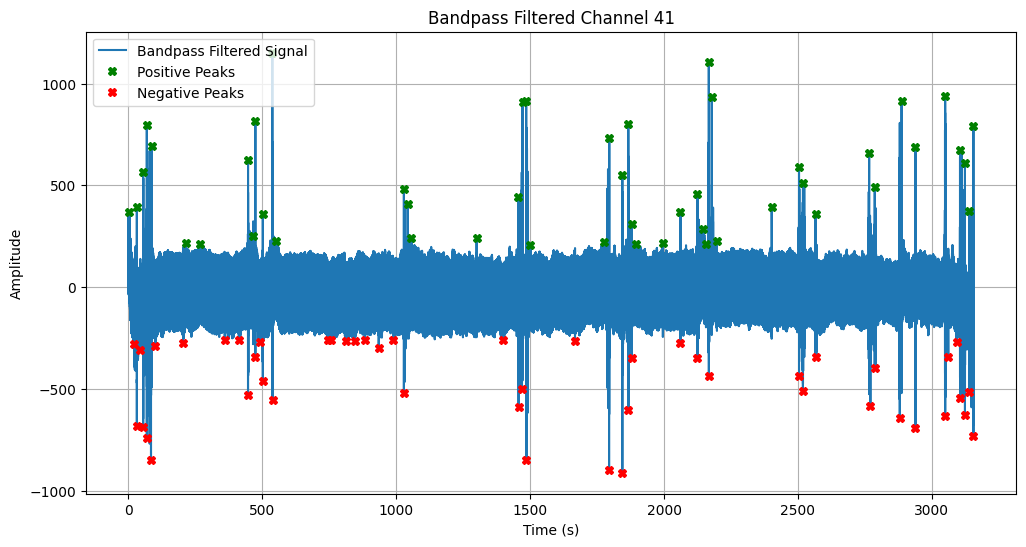

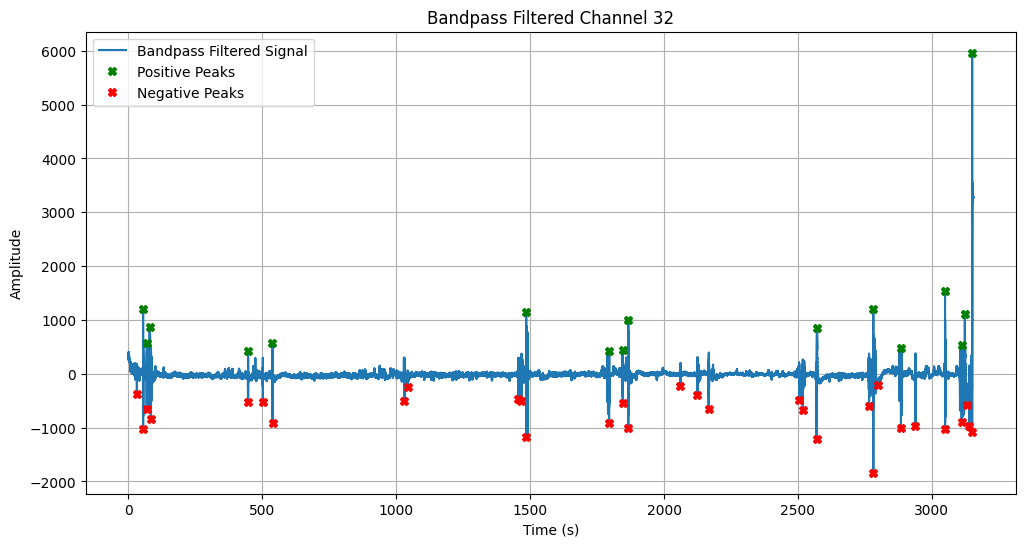

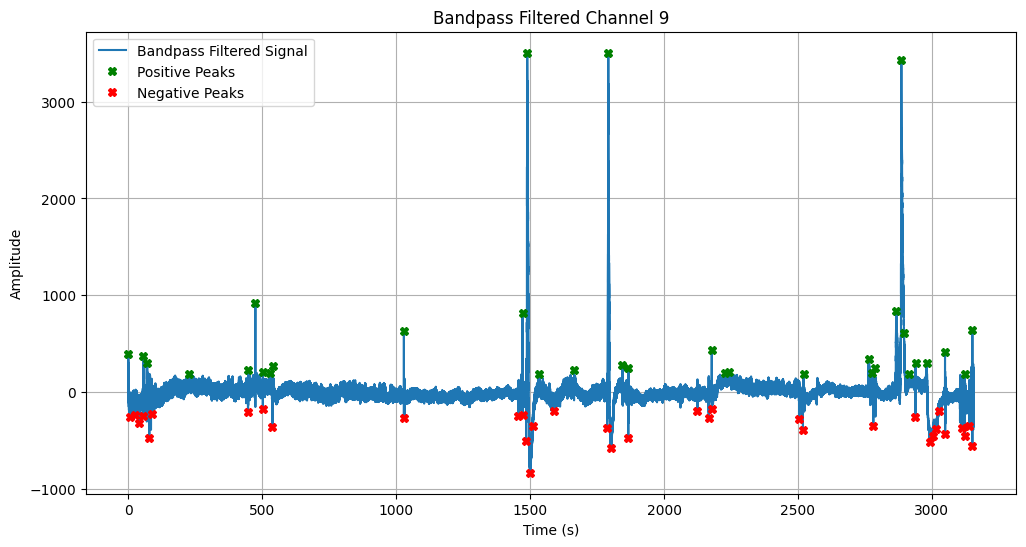

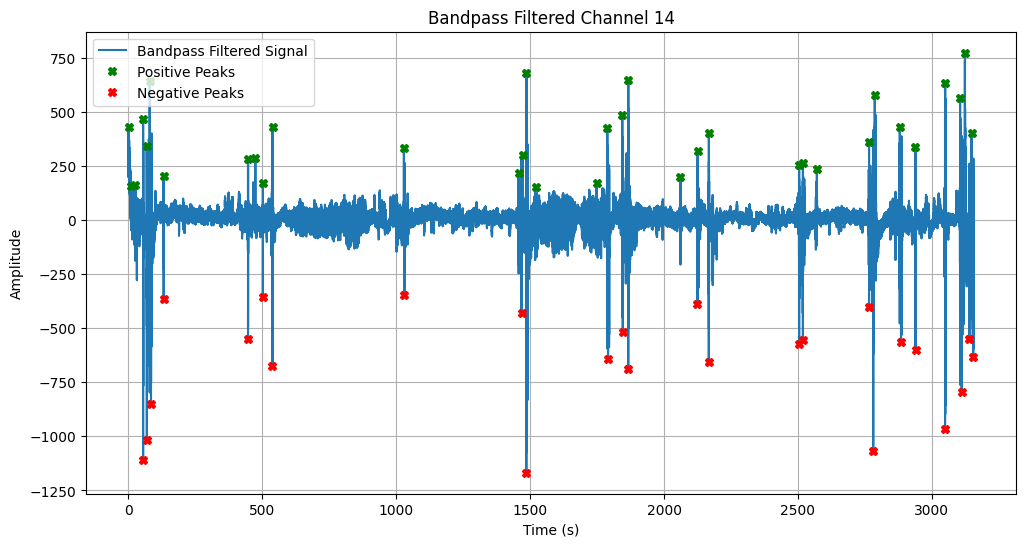

In [14]:
# Get 5 random channels to plot
random_channels = np.random.choice(num_channels, 5, replace = False)

# Define the sampling rate 
sampling_rate = 100 

distance_in_points = sampling_rate * 50  # Minimum distance between peaks in data points

# Plot each EEG channel separately
for i in range(len(random_channels)):
    # Smooth the signal
    smoothed_signal = apply_bandpass_filter(eeg_data[:, random_channels[i]], 0.5, 45, sfreq)
    
    # Subtract from the original signal to obtain spikes-only signal
    bandpass_filtered_signal = eeg_data[:, random_channels[i]] - smoothed_signal

    prominence_value = 50  # Only consider peaks with a prominence greater than this value
    height_threshold = 50   # Minimum peak height to consider
    
    # Find positive peaks
    positive_peaks, _ = find_peaks(bandpass_filtered_signal, prominence = prominence_value, height = height_threshold, distance = distance_in_points)
    
    # Find negative peaks
    negative_peaks, _ = find_peaks(-bandpass_filtered_signal, prominence = prominence_value, height = height_threshold, distance = distance_in_points)
    
    # Filter out peaks that are not in the top or bottom 20%
    if len(positive_peaks) > 0:
        top_threshold = np.percentile(bandpass_filtered_signal[positive_peaks], 80)
        positive_peaks = positive_peaks[bandpass_filtered_signal[positive_peaks] > top_threshold]
    
    if len(negative_peaks) > 0:
        bottom_threshold = np.percentile(bandpass_filtered_signal[negative_peaks], 20)
        negative_peaks = negative_peaks[bandpass_filtered_signal[negative_peaks] < bottom_threshold]
    
    # Plot the spikes-only signal
    plt.figure(figsize = (12, 6))
    plt.plot(time_axis, bandpass_filtered_signal, label = "Bandpass Filtered Signal")
    
    # Mark positive peaks with green X's
    plt.plot(time_axis[positive_peaks], bandpass_filtered_signal[positive_peaks], 'gX', label = "Positive Peaks")
    
    # Mark negative peaks with red X's
    plt.plot(time_axis[negative_peaks], bandpass_filtered_signal[negative_peaks], 'rX', label = "Negative Peaks")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Bandpass Filtered Channel {random_channels[i] + 1}")
    plt.legend()
    plt.grid(True)
    plt.show()

## Savitzky-Golay

### Sample Comparison

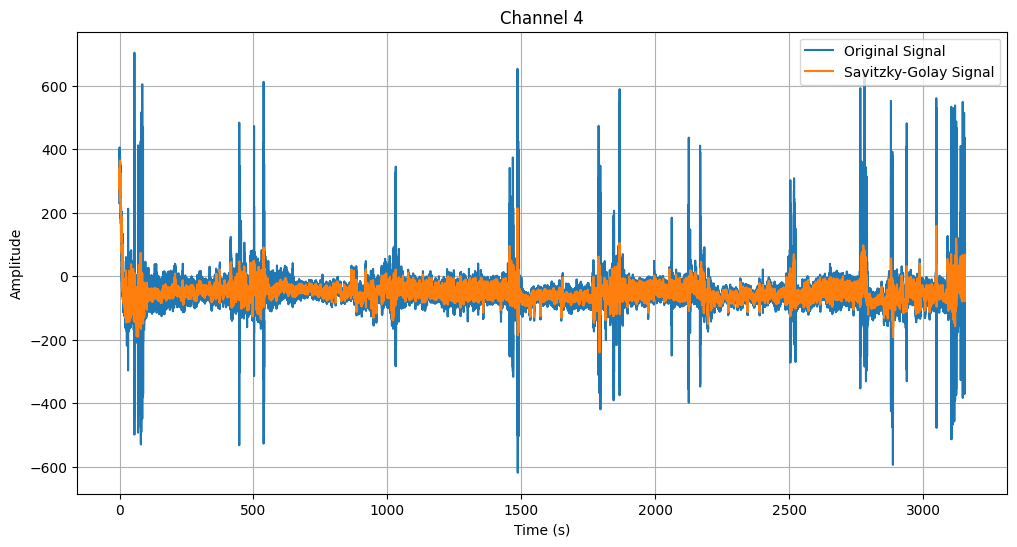

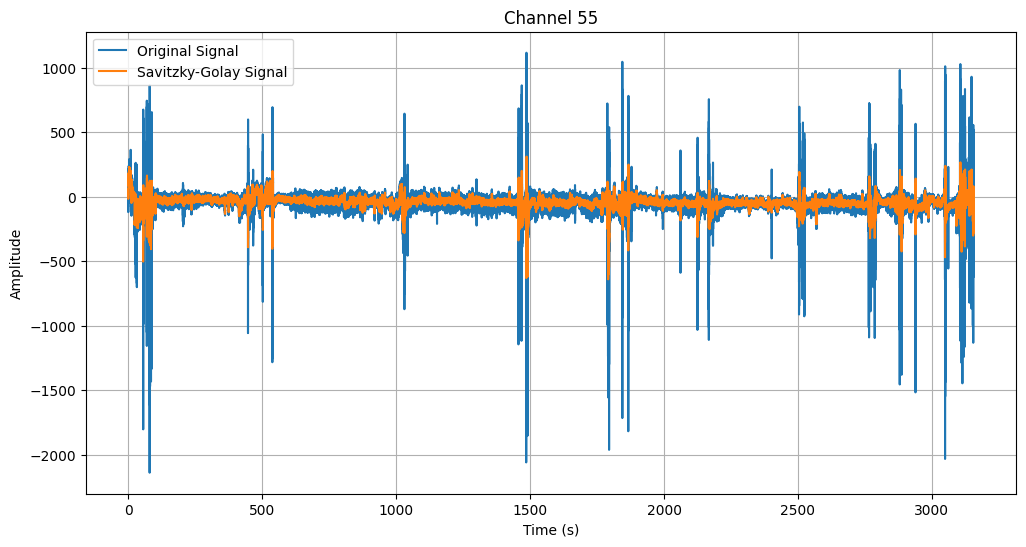

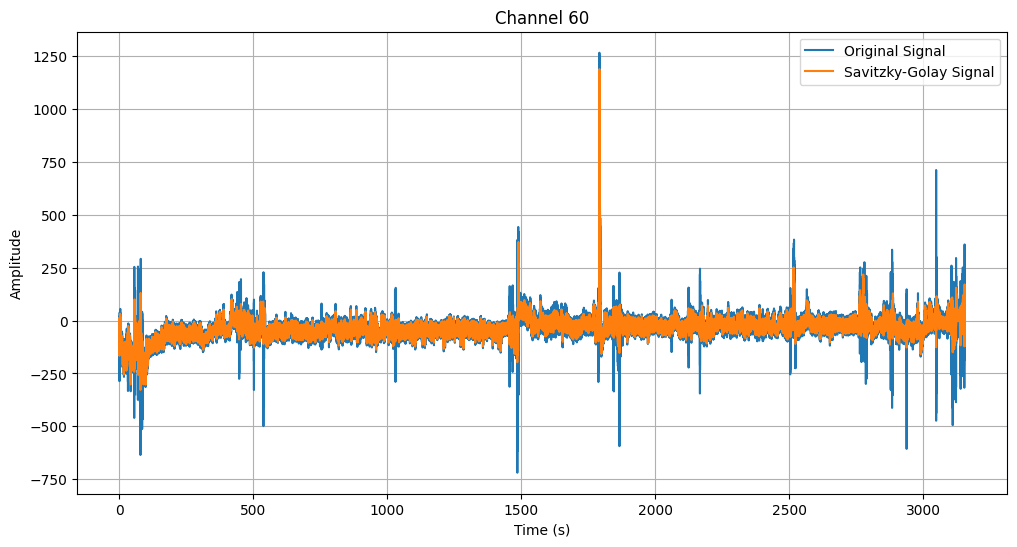

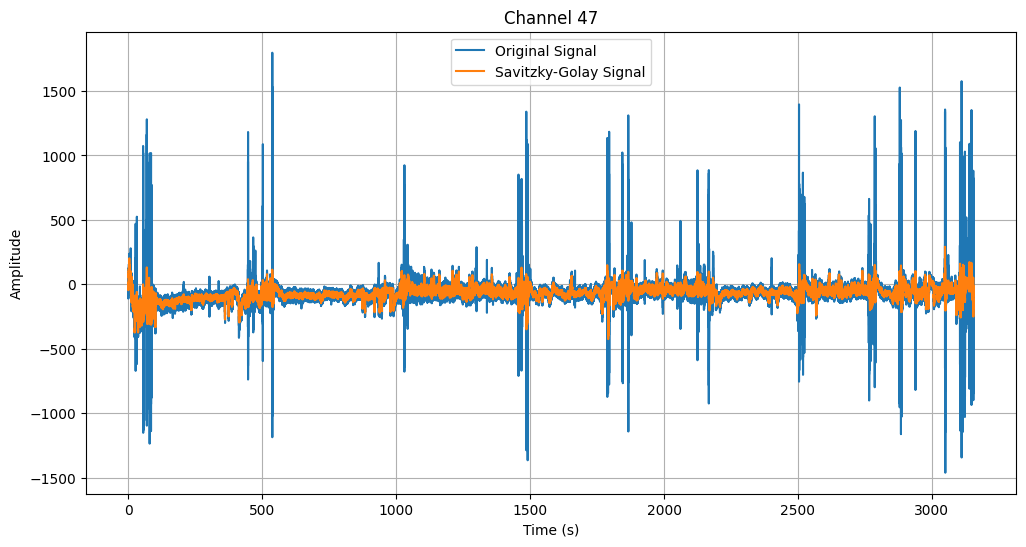

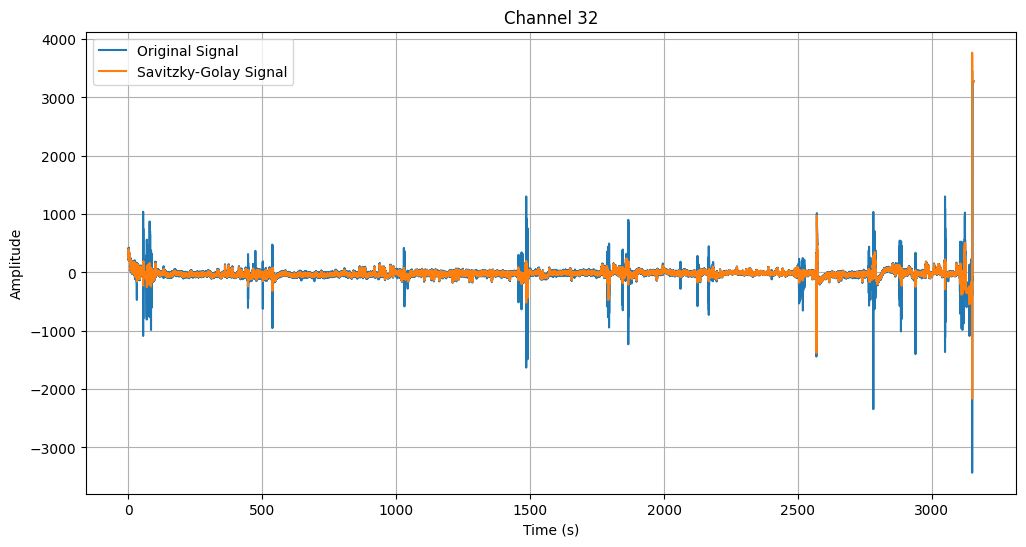

In [22]:
# Get 5 random channels to plot
random_channels = np.random.choice(num_channels, 5, replace=False)
        
# Plot each EEG channel separately
for i in range(len(random_channels)):
    # Smooth the signal using Savitzky-Golay filter
    smoothed_signal = savgol_filter(eeg_data[:, random_channels[i]], window_length=31, polyorder=3)
            
    # Plot the original signal, smoothed signal, and identified peaks
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, eeg_data[:, random_channels[i]], label="Original Signal")
    plt.plot(time_axis, smoothed_signal, label="Savitzky-Golay Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Channel {random_channels[i] + 1}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Peak Detection Attempt

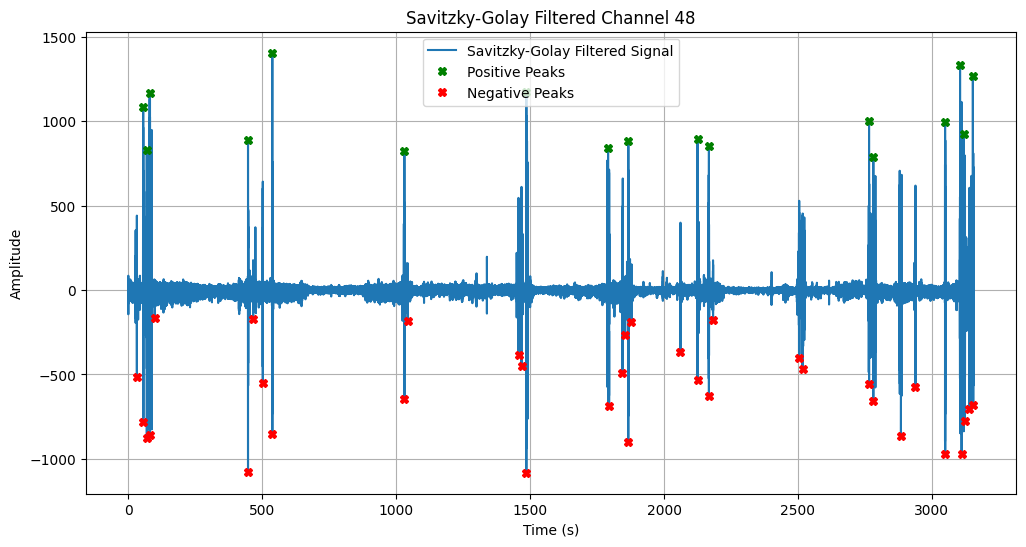

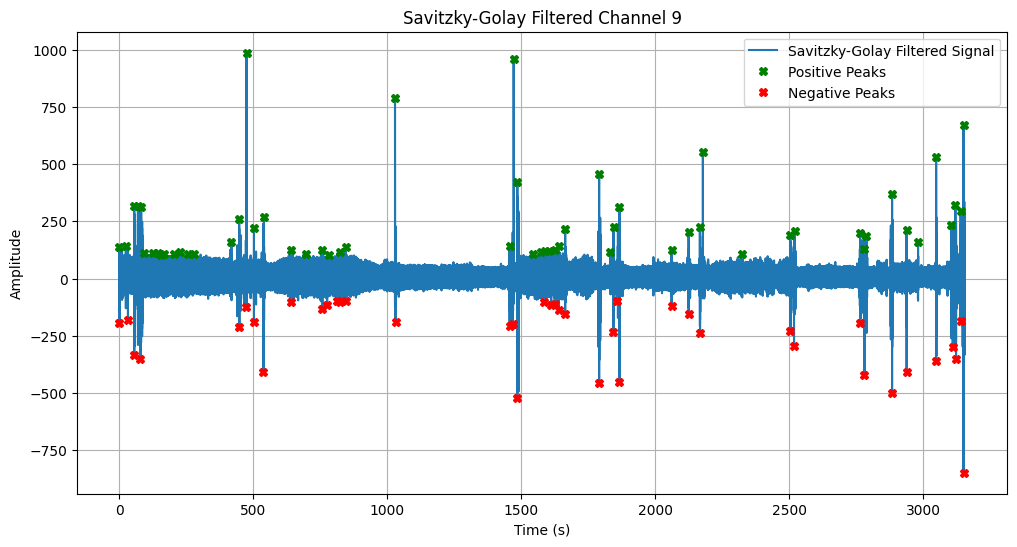

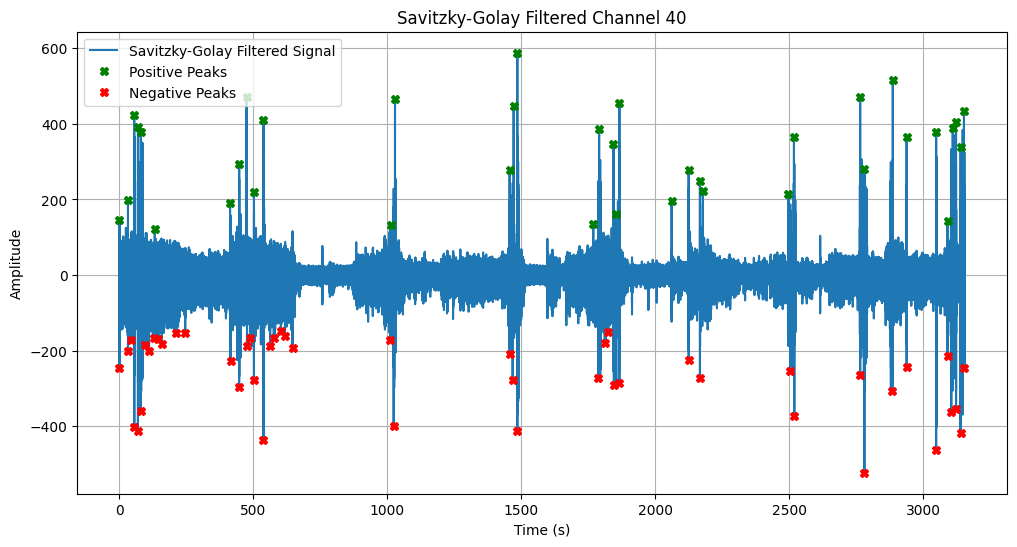

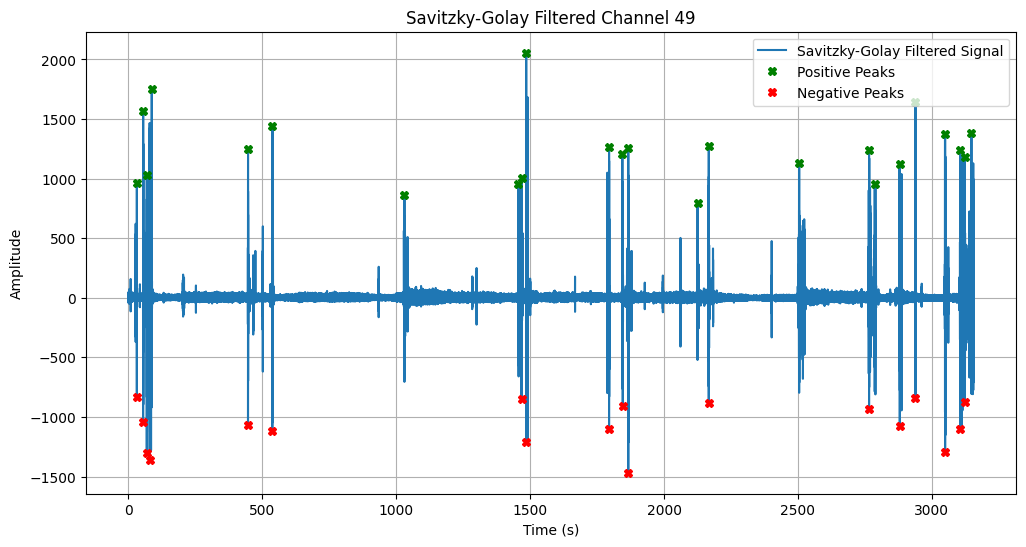

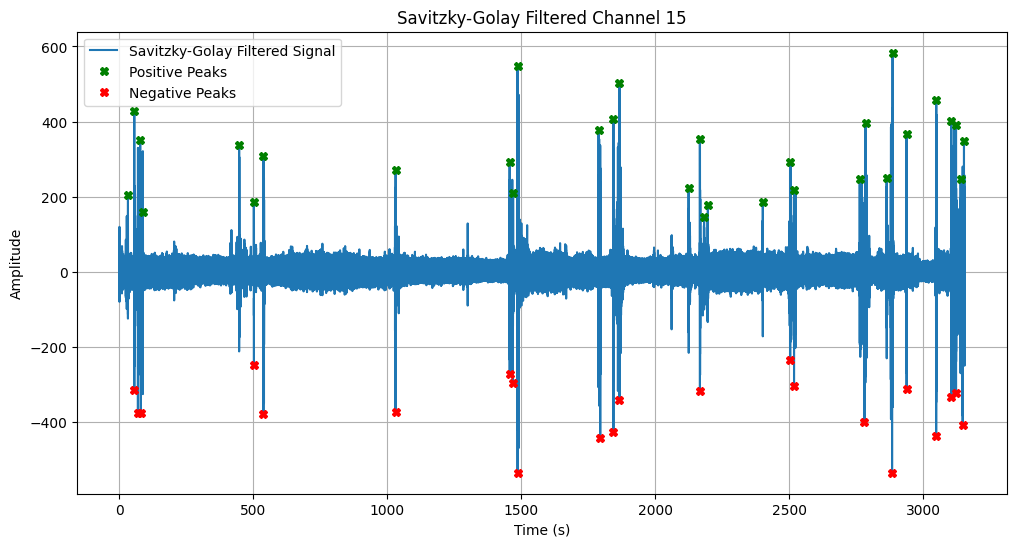

In [7]:
# Get 5 random channels to plot
random_channels = np.random.choice(num_channels, 5, replace = False)

# Define the sampling rate
sampling_rate = 100 

distance_in_points = sampling_rate * 50  # Minimum distance between peaks in data points

# Plot each EEG channel separately
for i in range(len(random_channels)):
    # Smooth the signal
    smoothed_signal = savgol_filter(eeg_data[:, random_channels[i]], window_length = 31, polyorder = 3)
    
    # Subtract from the original signal to obtain spikes-only signal
    savitzky_golay_filtered_signal = eeg_data[:, random_channels[i]] - smoothed_signal
    
    prominence_value = 50  # Only consider peaks with a prominence greater than this value
    height_threshold = 50   # Minimum peak height to consider
    
    # Find positive peaks
    positive_peaks, _ = find_peaks(savitzky_golay_filtered_signal, prominence = prominence_value, height = height_threshold, distance = distance_in_points)
    
    # Find negative peaks
    negative_peaks, _ = find_peaks(-savitzky_golay_filtered_signal, prominence = prominence_value, height = height_threshold, distance = distance_in_points)
    
    # Filter out peaks that are not in the topor bottom 25%
    if len(positive_peaks) > 0:
        top_threshold = np.percentile(savitzky_golay_filtered_signal[positive_peaks], 75)
        positive_peaks = positive_peaks[savitzky_golay_filtered_signal[positive_peaks] > top_threshold]
    
    if len(negative_peaks) > 0:
        bottom_threshold = np.percentile(savitzky_golay_filtered_signal[negative_peaks], 25)
        negative_peaks = negative_peaks[savitzky_golay_filtered_signal[negative_peaks] < bottom_threshold]
    
    # Plot the spikes-only signal
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, savitzky_golay_filtered_signal, label = "Savitzky-Golay Filtered Signal")
    
    # Mark positive peaks with green X's
    plt.plot(time_axis[positive_peaks], savitzky_golay_filtered_signal[positive_peaks], 'gX', label = "Positive Peaks")
    
    # Mark negative peaks with red X's
    plt.plot(time_axis[negative_peaks], savitzky_golay_filtered_signal[negative_peaks], 'rX', label = "Negative Peaks")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Savitzky-Golay Filtered Channel {random_channels[i] + 1}")
    plt.legend()
    plt.grid(True)
    plt.show()